In [1]:
import math

import import_ipynb
from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from aqi_epa_pm25.ipynb
PM2.5: 35.9, AQI: 102
PM2.5: 35.9, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 35.5, Max: 55.4
AQI: 102, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 101, Max: 150


## PM2.5 Clean Data

In [2]:
# Load Raw Data
df_pm25_raw = df_from_csv("pm25_raw.csv")

# Check Data Types
print(df_pm25_raw.dtypes)

df_pm25_raw.head()

TANGARA_2BBA    float64
TANGARA_260A    float64
TANGARA_4B1A    float64
TANGARA_1EE6    float64
TANGARA_2B42    float64
TANGARA_2E9A    float64
TANGARA_2FF6    float64
TANGARA_307A    float64
TANGARA_1712    float64
TANGARA_48C6    float64
TANGARA_532E    float64
TANGARA_F1AE    float64
TANGARA_06BE    float64
dtype: object


,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
DATETIME,,,,,,,,,,,,,
2023-10-05 12:51:30-05:00,7.0,9.0,11.0,14.0,11.0,9.0,11.0,8.0,10.0,14.0,11.0,11.0,0.0
2023-10-05 12:52:00-05:00,7.0,9.0,10.0,14.0,10.0,10.0,10.0,8.0,9.0,NaN,10.0,11.0,0.0
2023-10-05 12:52:30-05:00,6.0,9.0,11.0,14.0,10.0,9.0,10.0,8.0,9.0,12.0,9.0,11.0,0.0
2023-10-05 12:53:00-05:00,6.0,9.0,10.0,13.0,12.0,9.0,10.0,8.0,8.0,10.0,9.0,12.0,0.0
2023-10-05 12:53:30-05:00,6.0,10.0,10.0,14.0,10.0,9.0,9.0,9.0,7.0,9.0,10.0,9.0,0.0


## Descriptive Statistics

In [3]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,900.000000,893.000000,890.000000,887.000000,894.000000,886.000000,887.000000,876.000000,888.000000,865.000000,888.000000,898.000000,893.000000
mean,5.093333,5.674132,11.129213,18.420519,4.869128,10.351016,5.523112,8.638128,9.150901,5.040462,6.862613,5.620267,0.001120
std,2.734886,3.129881,10.055982,17.549033,3.315728,10.727220,3.649001,5.116504,5.769900,3.336385,6.259265,3.063707,0.033464
min,2.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,0.000000,0.000000,2.000000,0.000000
25%,3.000000,4.000000,5.000000,7.000000,3.000000,3.000000,3.000000,4.000000,4.000000,3.000000,2.000000,4.000000,0.000000
50%,4.000000,5.000000,8.000000,13.000000,3.000000,7.000000,4.000000,9.000000,9.000000,4.000000,4.000000,5.000000,0.000000
75%,8.000000,6.000000,11.000000,24.000000,6.000000,12.000000,9.000000,11.000000,11.000000,8.000000,11.000000,6.000000,0.000000
max,17.000000,17.000000,62.000000,158.000000,15.000000,72.000000,17.000000,101.000000,59.000000,16.000000,28.000000,22.000000,1.000000


## Missing Data

In [4]:
# Missing Data Threshold
threshold = 90
print(f'Threshold: {threshold}%')

# For each Tangara sensor
for id_tangara_sensor in df_pm25_raw.columns:
    df_pm25_sensor = df_pm25_raw[[id_tangara_sensor]]
    # To be checked
    is_ok, data_percent, missing_data_percent = to_be_checked(df_pm25_sensor, threshold)
    if not is_ok:
        print(f"Tangara Sensor: {id_tangara_sensor}, Data: {data_percent}%, Missing: {missing_data_percent}%, To be checked")

Threshold: 90%


## Data Correlation

In [5]:
# Data Correlation Threshold
threshold = 0.9
print(f'Threshold: {threshold}%')

ID_REFE_TANGARA_SENSOR='TANGARA_06BE'
ID_TARG_TANGARA_SENSOR='TANGARA_2FF6'
# Reference Tangara Sensor
df_reference_sensor = df_pm25_raw[ID_REFE_TANGARA_SENSOR]
# Target Tangara Sensor
df_target_sensor = df_pm25_raw[ID_TARG_TANGARA_SENSOR]

# To be checked
is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
if not is_ok:
    print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {ID_TARG_TANGARA_SENSOR}, Correlation: {corr}, To be checked")

# For each Tangara sensor
# for id_tangara_sensor in df_pm25_raw.columns:
#     # Target Tangara Sensor
#     df_target_sensor = df_pm25_raw[id_tangara_sensor]
#     # To be checked
#     is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
#     if not is_ok:
#         print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {id_tangara_sensor}, Correlation: {corr}, To be checked")

Threshold: 0.9%
Reference Tangara Sensor: TANGARA_06BE, Target Tangara Sensor: TANGARA_2FF6, Correlation: 0.0, To be checked


## Histograms

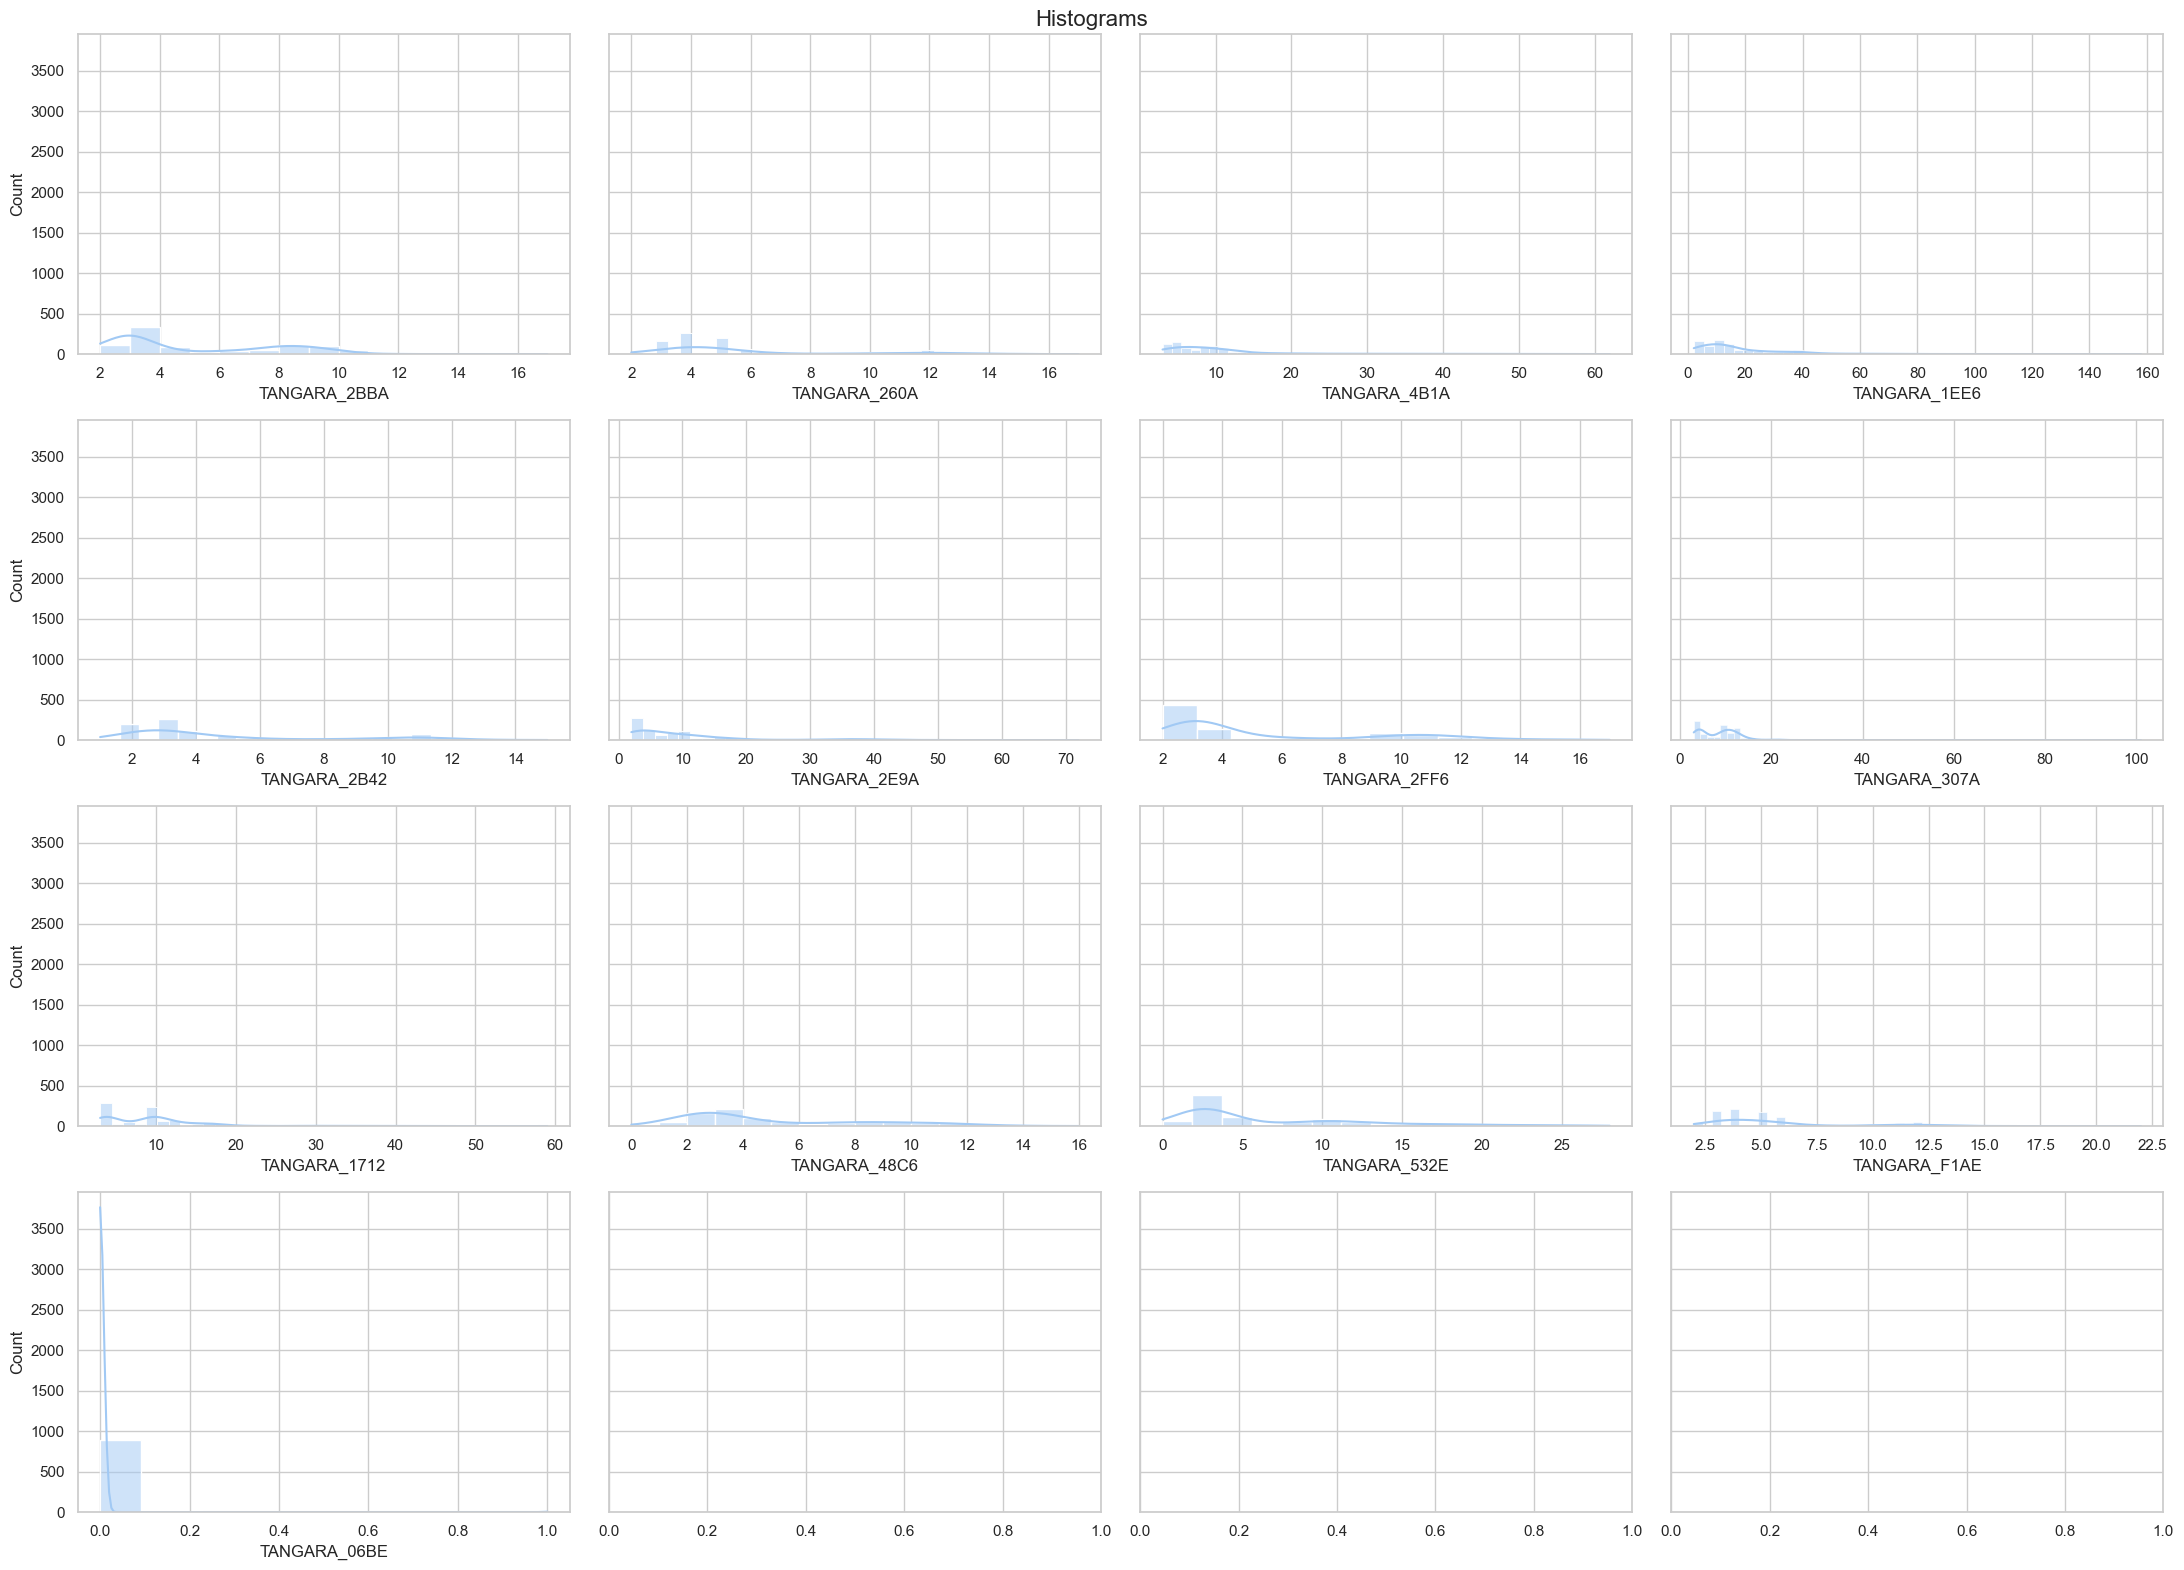

In [6]:
# Plot Histograms
plot_hist(df_pm25_raw)

## Boxplots

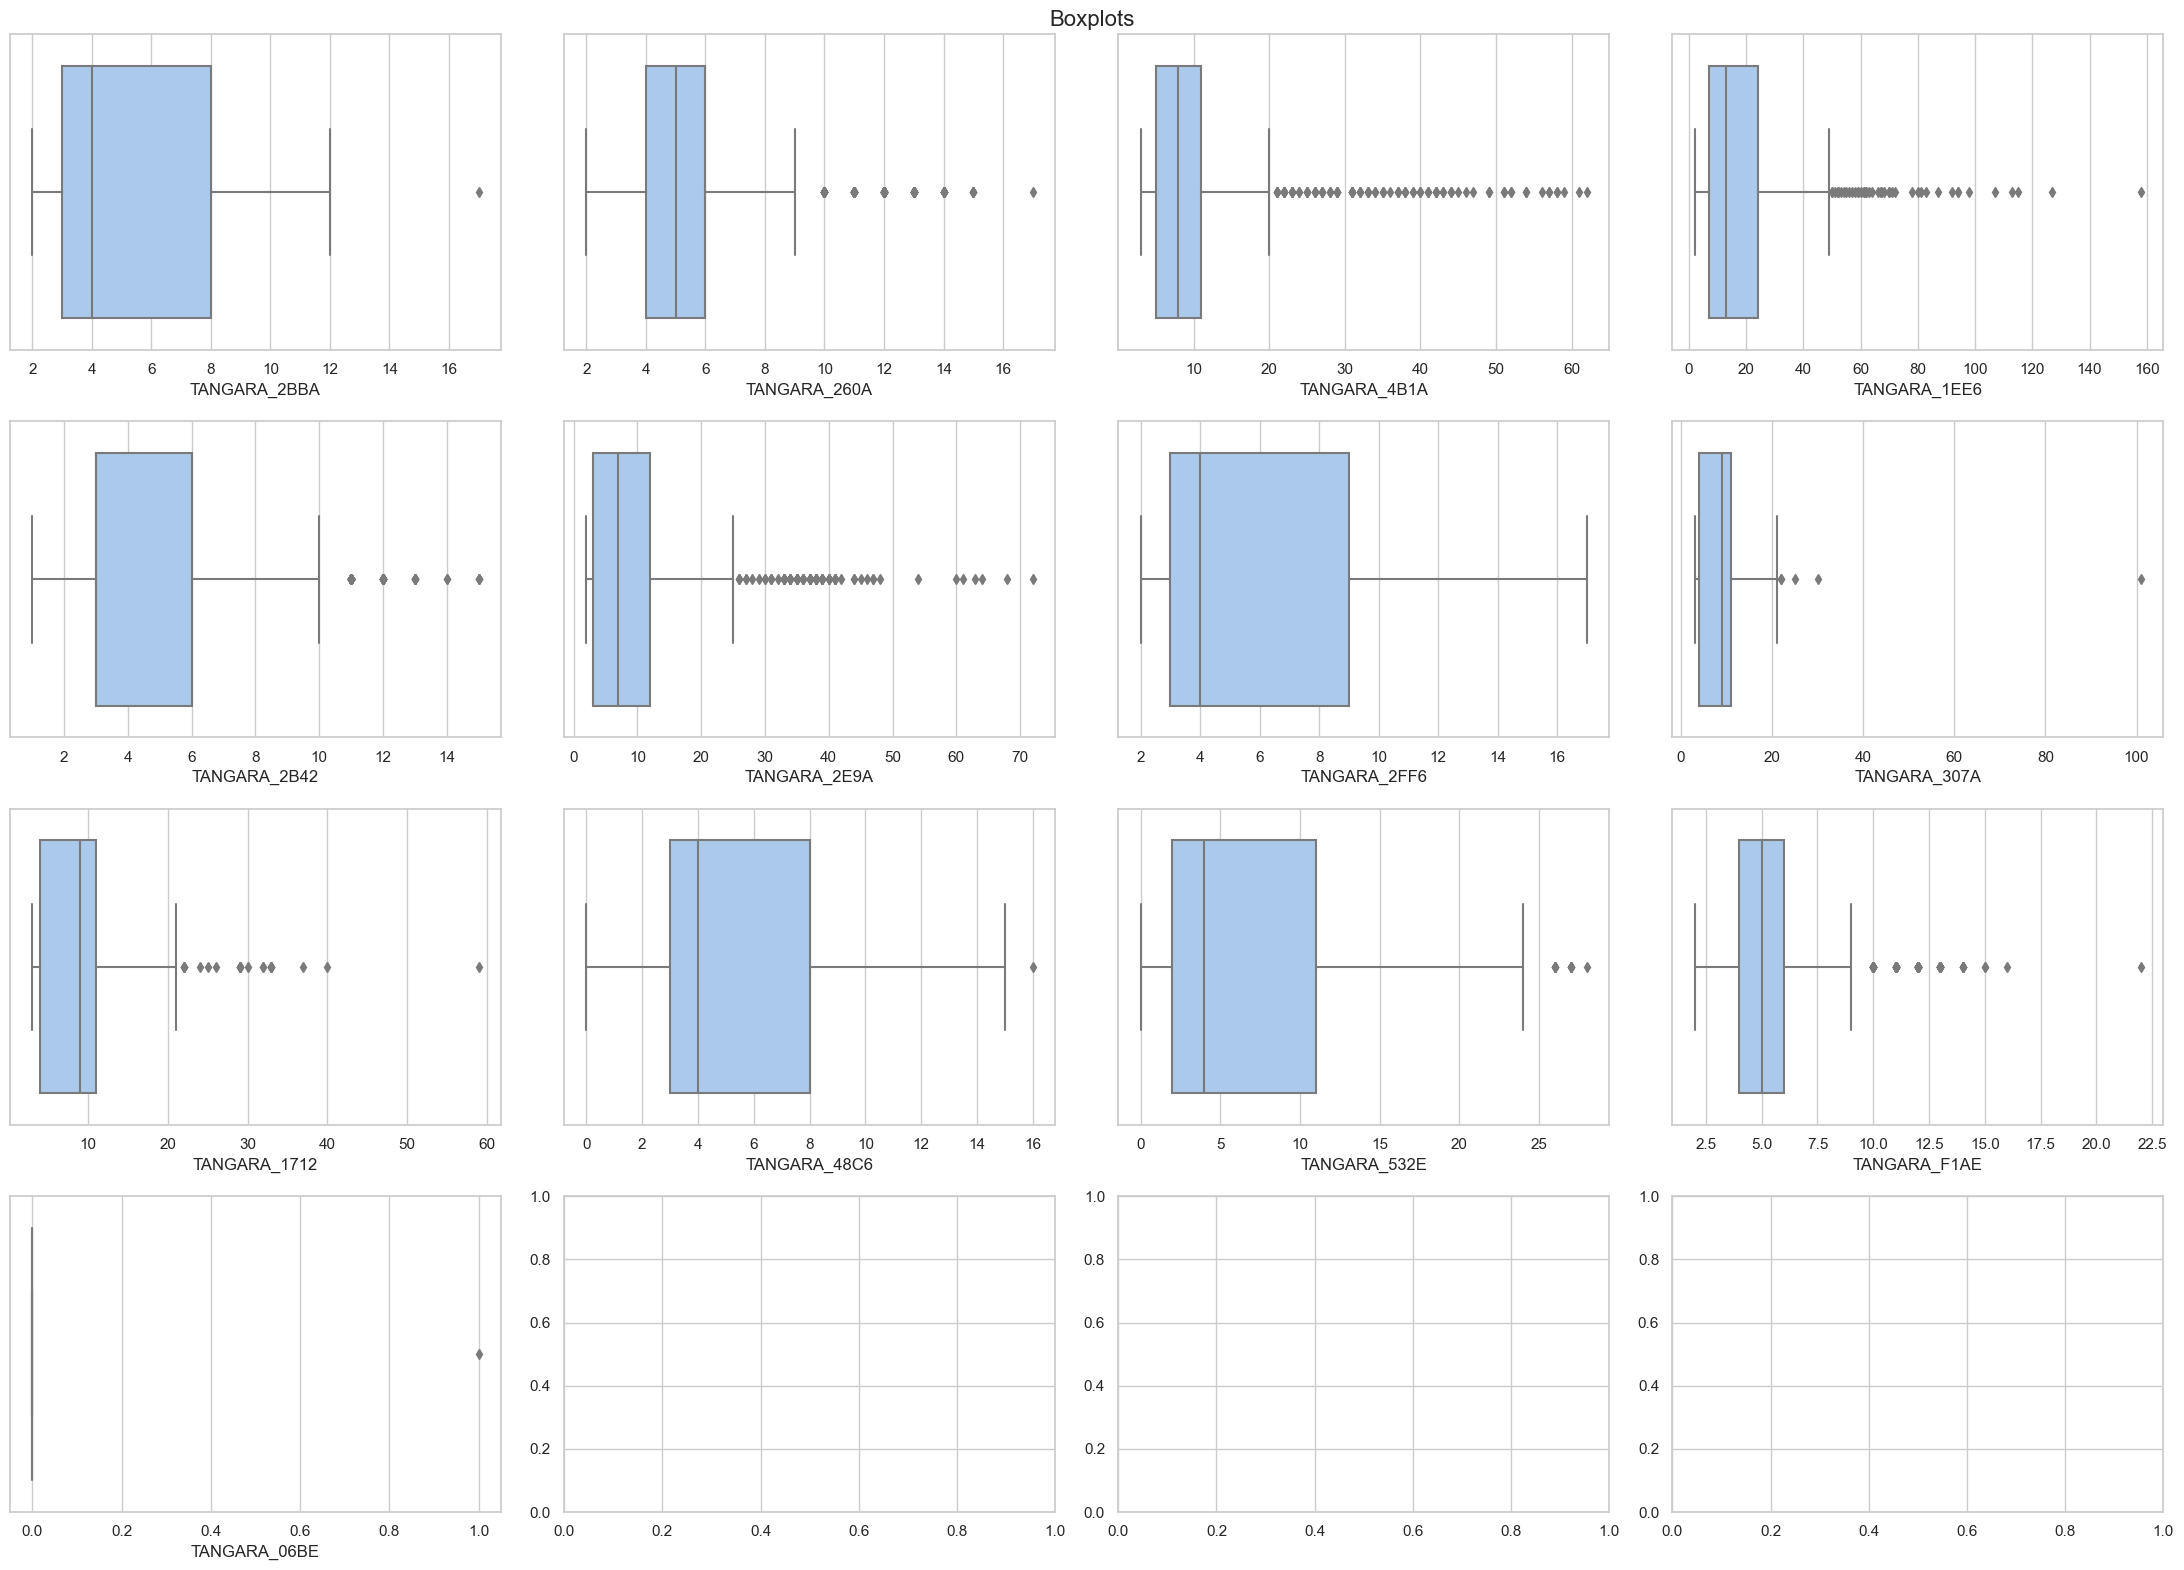

In [7]:
# Plot Boxplots
plot_boxes(df_pm25_raw)

## Lineplots

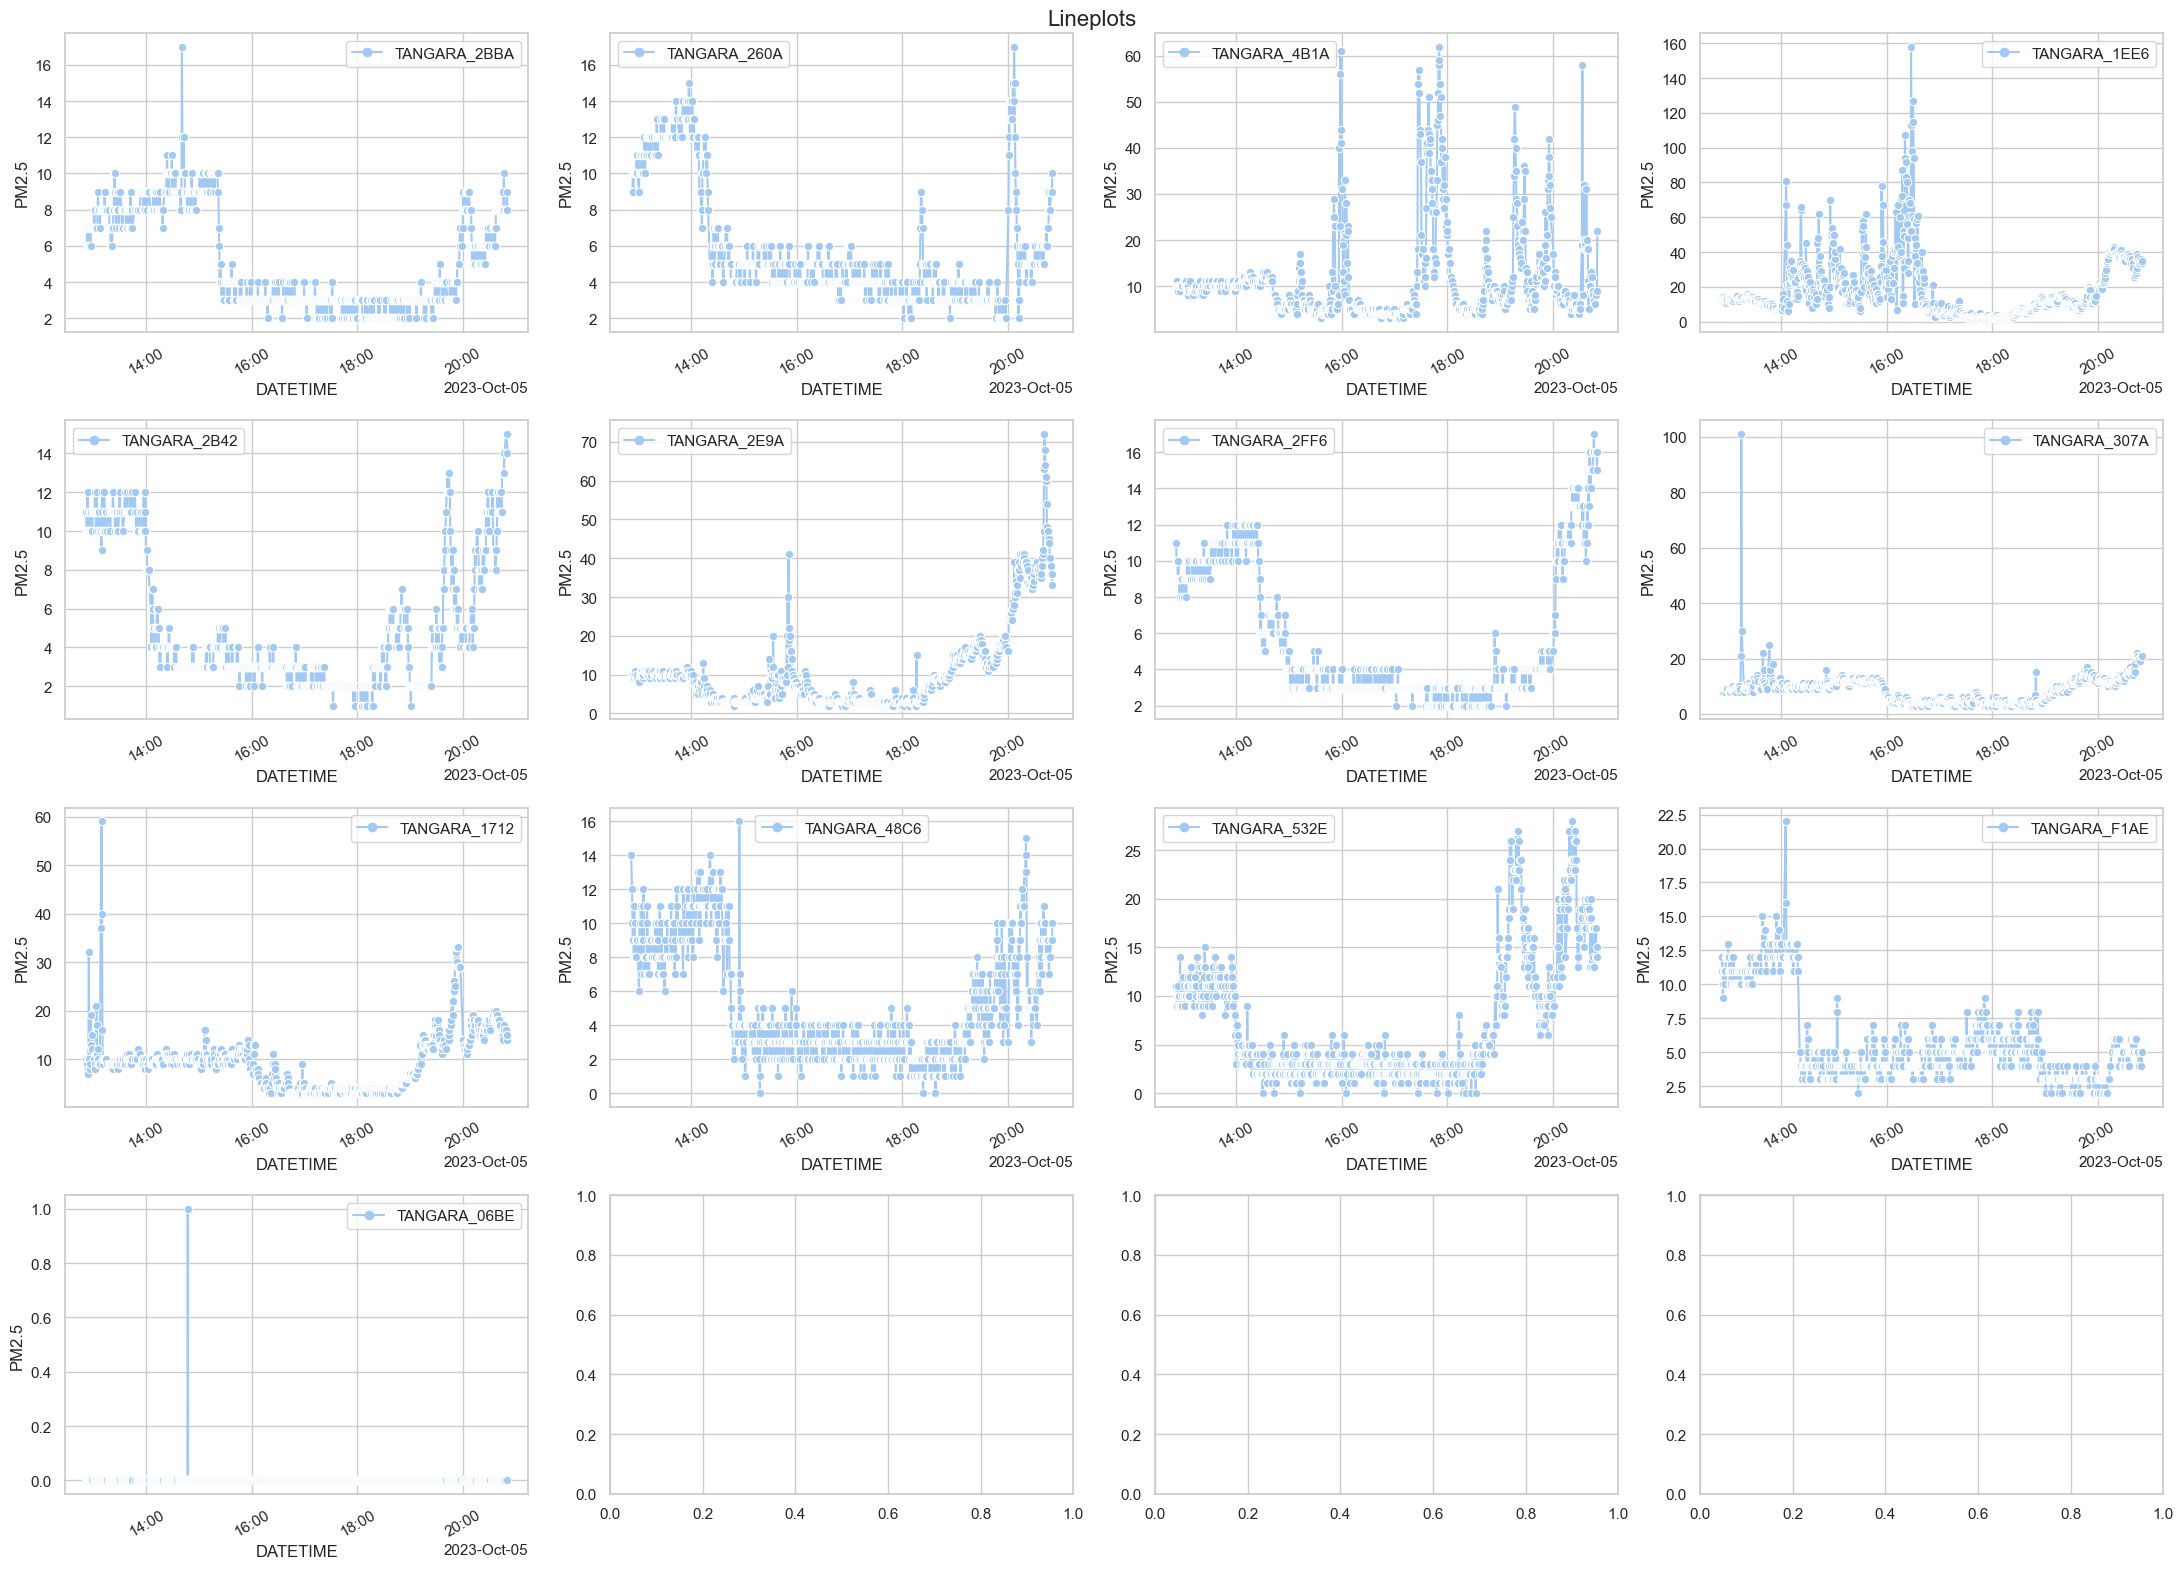

In [8]:
# Plot Lineplots
plot_lines(df_pm25_raw)

## Drop PM2.5 Outliers

In [9]:
# Drop PM2.5 Outliers
df_pm25_clean, resume = drop_pm25_outliers(df_pm25_raw)

In [10]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,899.000000,745.000000,788.000000,842.000000,779.000000,799.000000,887.000000,871.000000,864.000000,864.000000,877.000000,750.000000,892.0
mean,5.080089,4.412081,8.013959,15.513064,3.885751,7.289111,5.523112,8.458094,8.557870,5.027778,6.614595,4.406667,0.0
std,2.707375,1.328195,3.670489,11.398122,2.230552,4.863322,3.649001,3.904937,4.426705,3.317382,5.890141,1.364712,0.0
min,2.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,0.000000,0.000000,2.000000,0.0
25%,3.000000,4.000000,5.000000,7.000000,2.000000,3.000000,3.000000,4.000000,4.000000,3.000000,2.000000,3.000000,0.0
50%,4.000000,4.000000,7.000000,12.000000,3.000000,6.000000,4.000000,9.000000,9.000000,4.000000,4.000000,4.000000,0.0
75%,8.000000,5.000000,10.000000,22.000000,5.000000,10.000000,9.000000,11.000000,11.000000,8.000000,10.000000,5.000000,0.0
max,12.000000,9.000000,20.000000,49.000000,10.000000,25.000000,17.000000,21.000000,21.000000,15.000000,24.000000,9.000000,0.0


In [11]:
# Describe Data
df_pm25_clean.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,899.000000,745.000000,788.000000,842.000000,779.000000,799.000000,887.000000,871.000000,864.000000,864.000000,877.000000,750.000000,892.0
mean,5.080089,4.412081,8.013959,15.513064,3.885751,7.289111,5.523112,8.458094,8.557870,5.027778,6.614595,4.406667,0.0
std,2.707375,1.328195,3.670489,11.398122,2.230552,4.863322,3.649001,3.904937,4.426705,3.317382,5.890141,1.364712,0.0
min,2.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,0.000000,0.000000,2.000000,0.0
25%,3.000000,4.000000,5.000000,7.000000,2.000000,3.000000,3.000000,4.000000,4.000000,3.000000,2.000000,3.000000,0.0
50%,4.000000,4.000000,7.000000,12.000000,3.000000,6.000000,4.000000,9.000000,9.000000,4.000000,4.000000,4.000000,0.0
75%,8.000000,5.000000,10.000000,22.000000,5.000000,10.000000,9.000000,11.000000,11.000000,8.000000,10.000000,5.000000,0.0
max,12.000000,9.000000,20.000000,49.000000,10.000000,25.000000,17.000000,21.000000,21.000000,15.000000,24.000000,9.000000,0.0


## Histograms

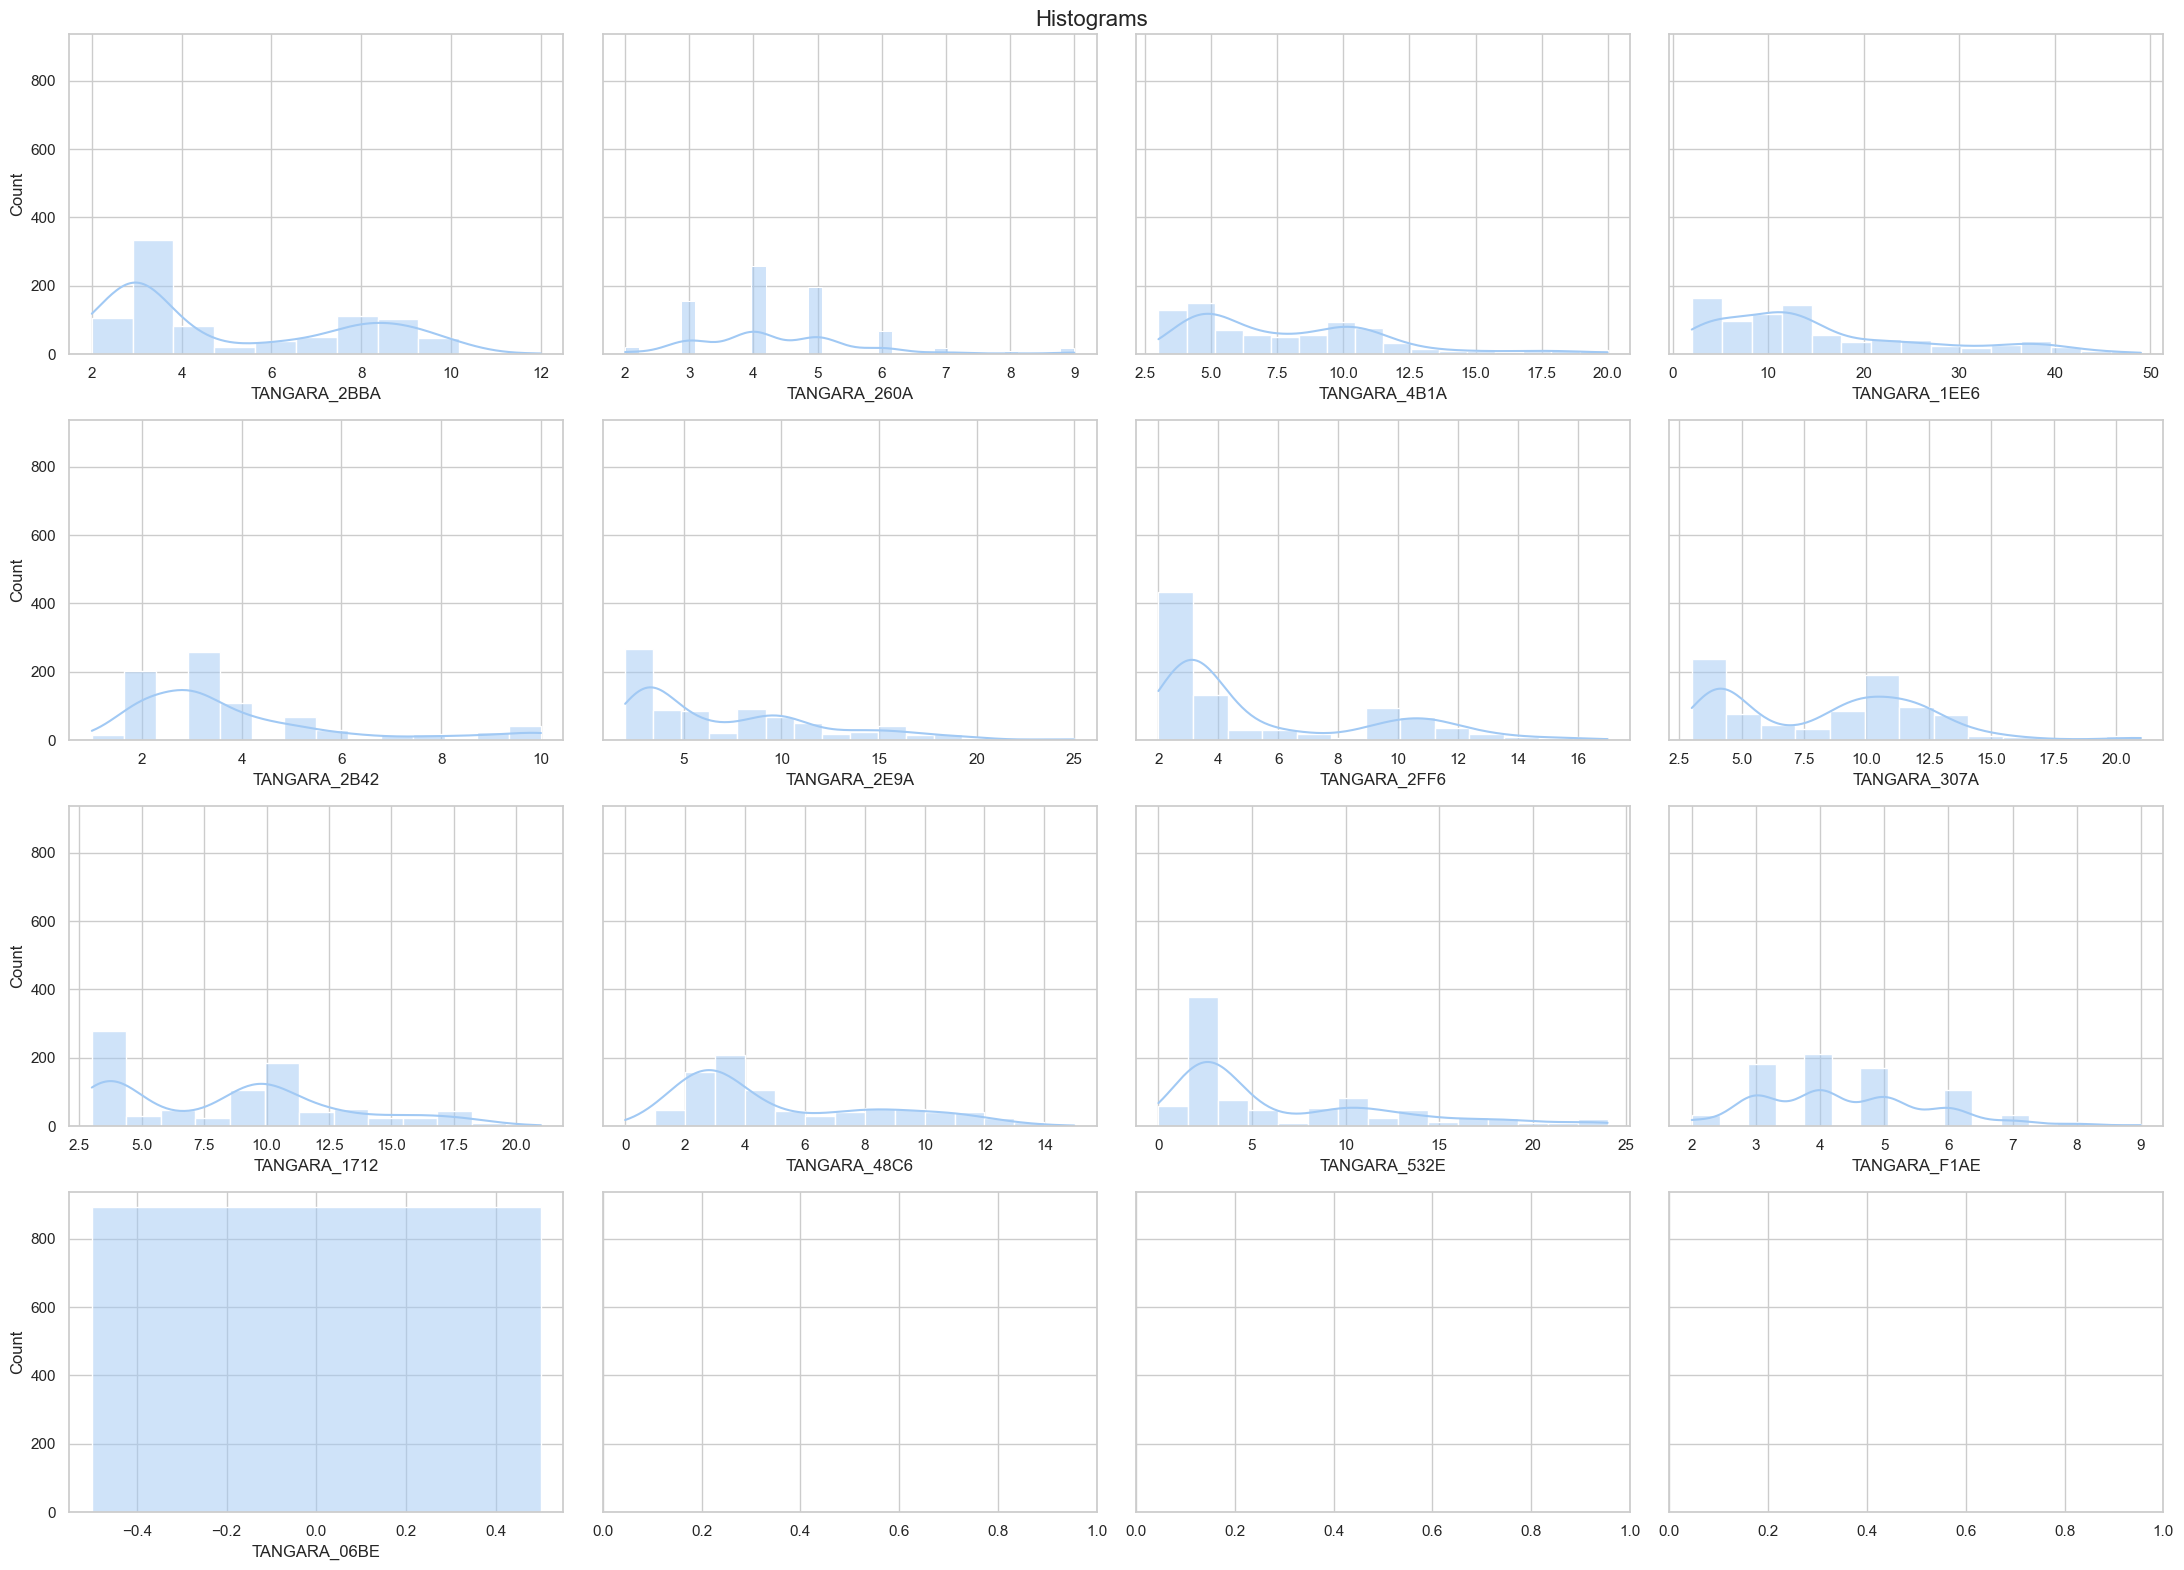

In [12]:
# Plot Histograms
plot_hist(df_pm25_clean)

## Boxplots

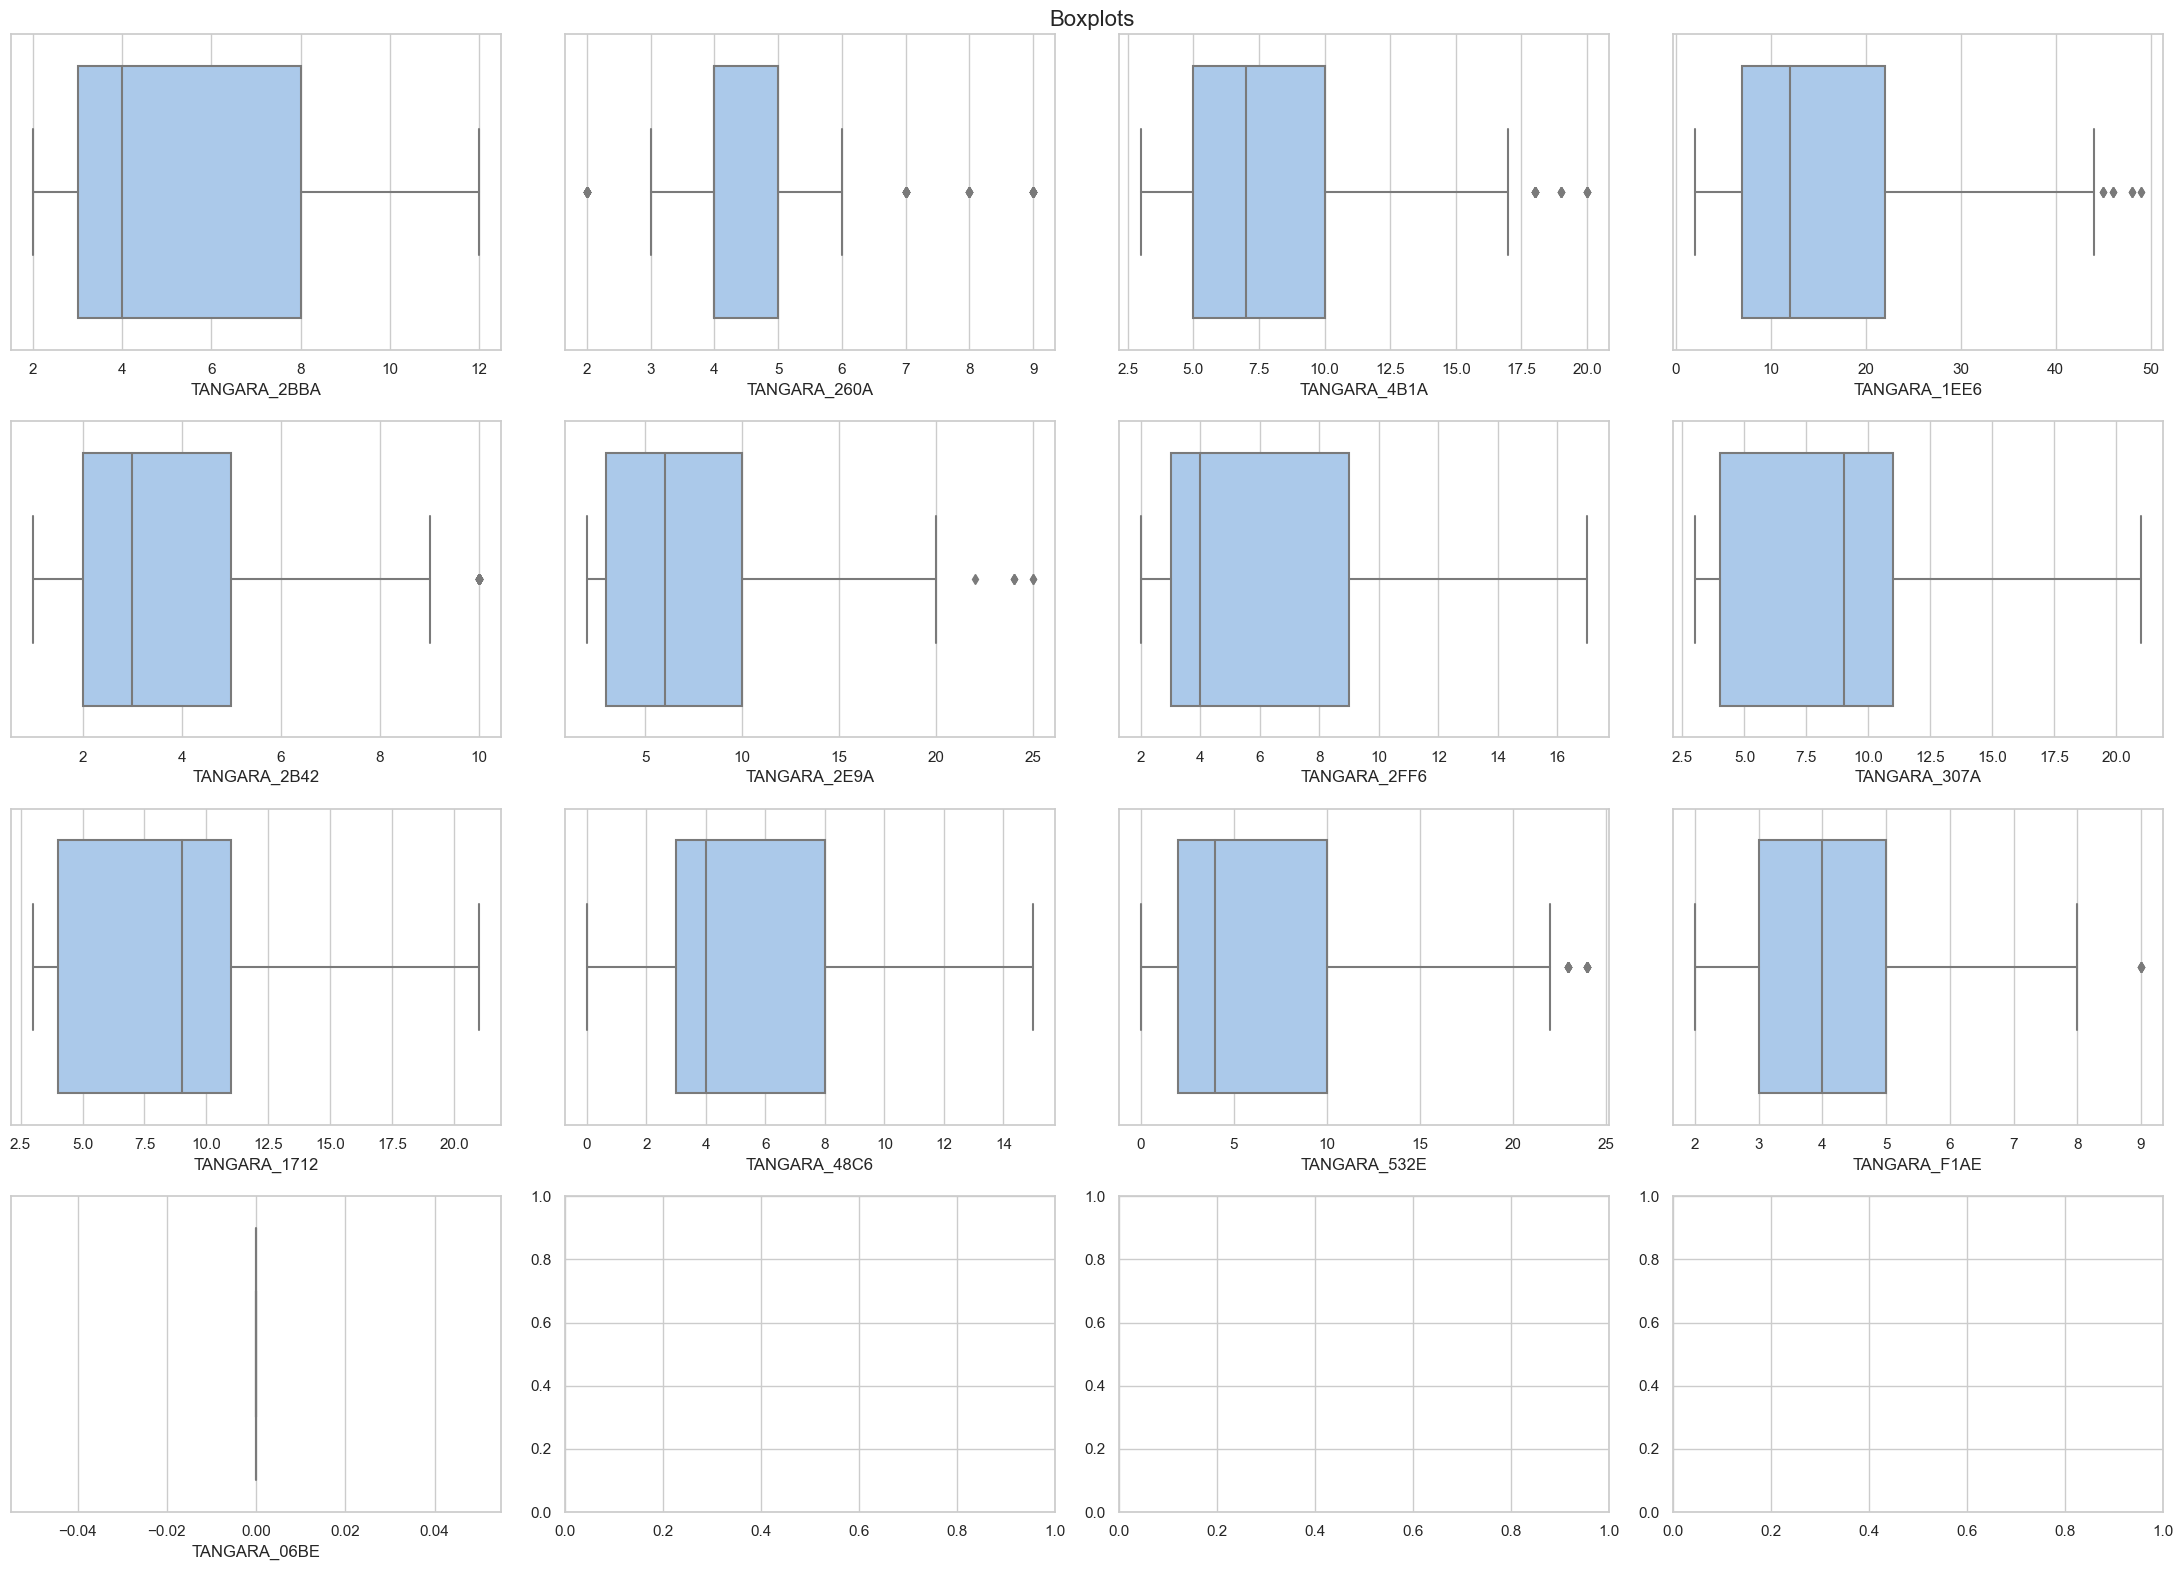

In [13]:
# Plot Boxplots
plot_boxes(df_pm25_clean)

## Lineplots

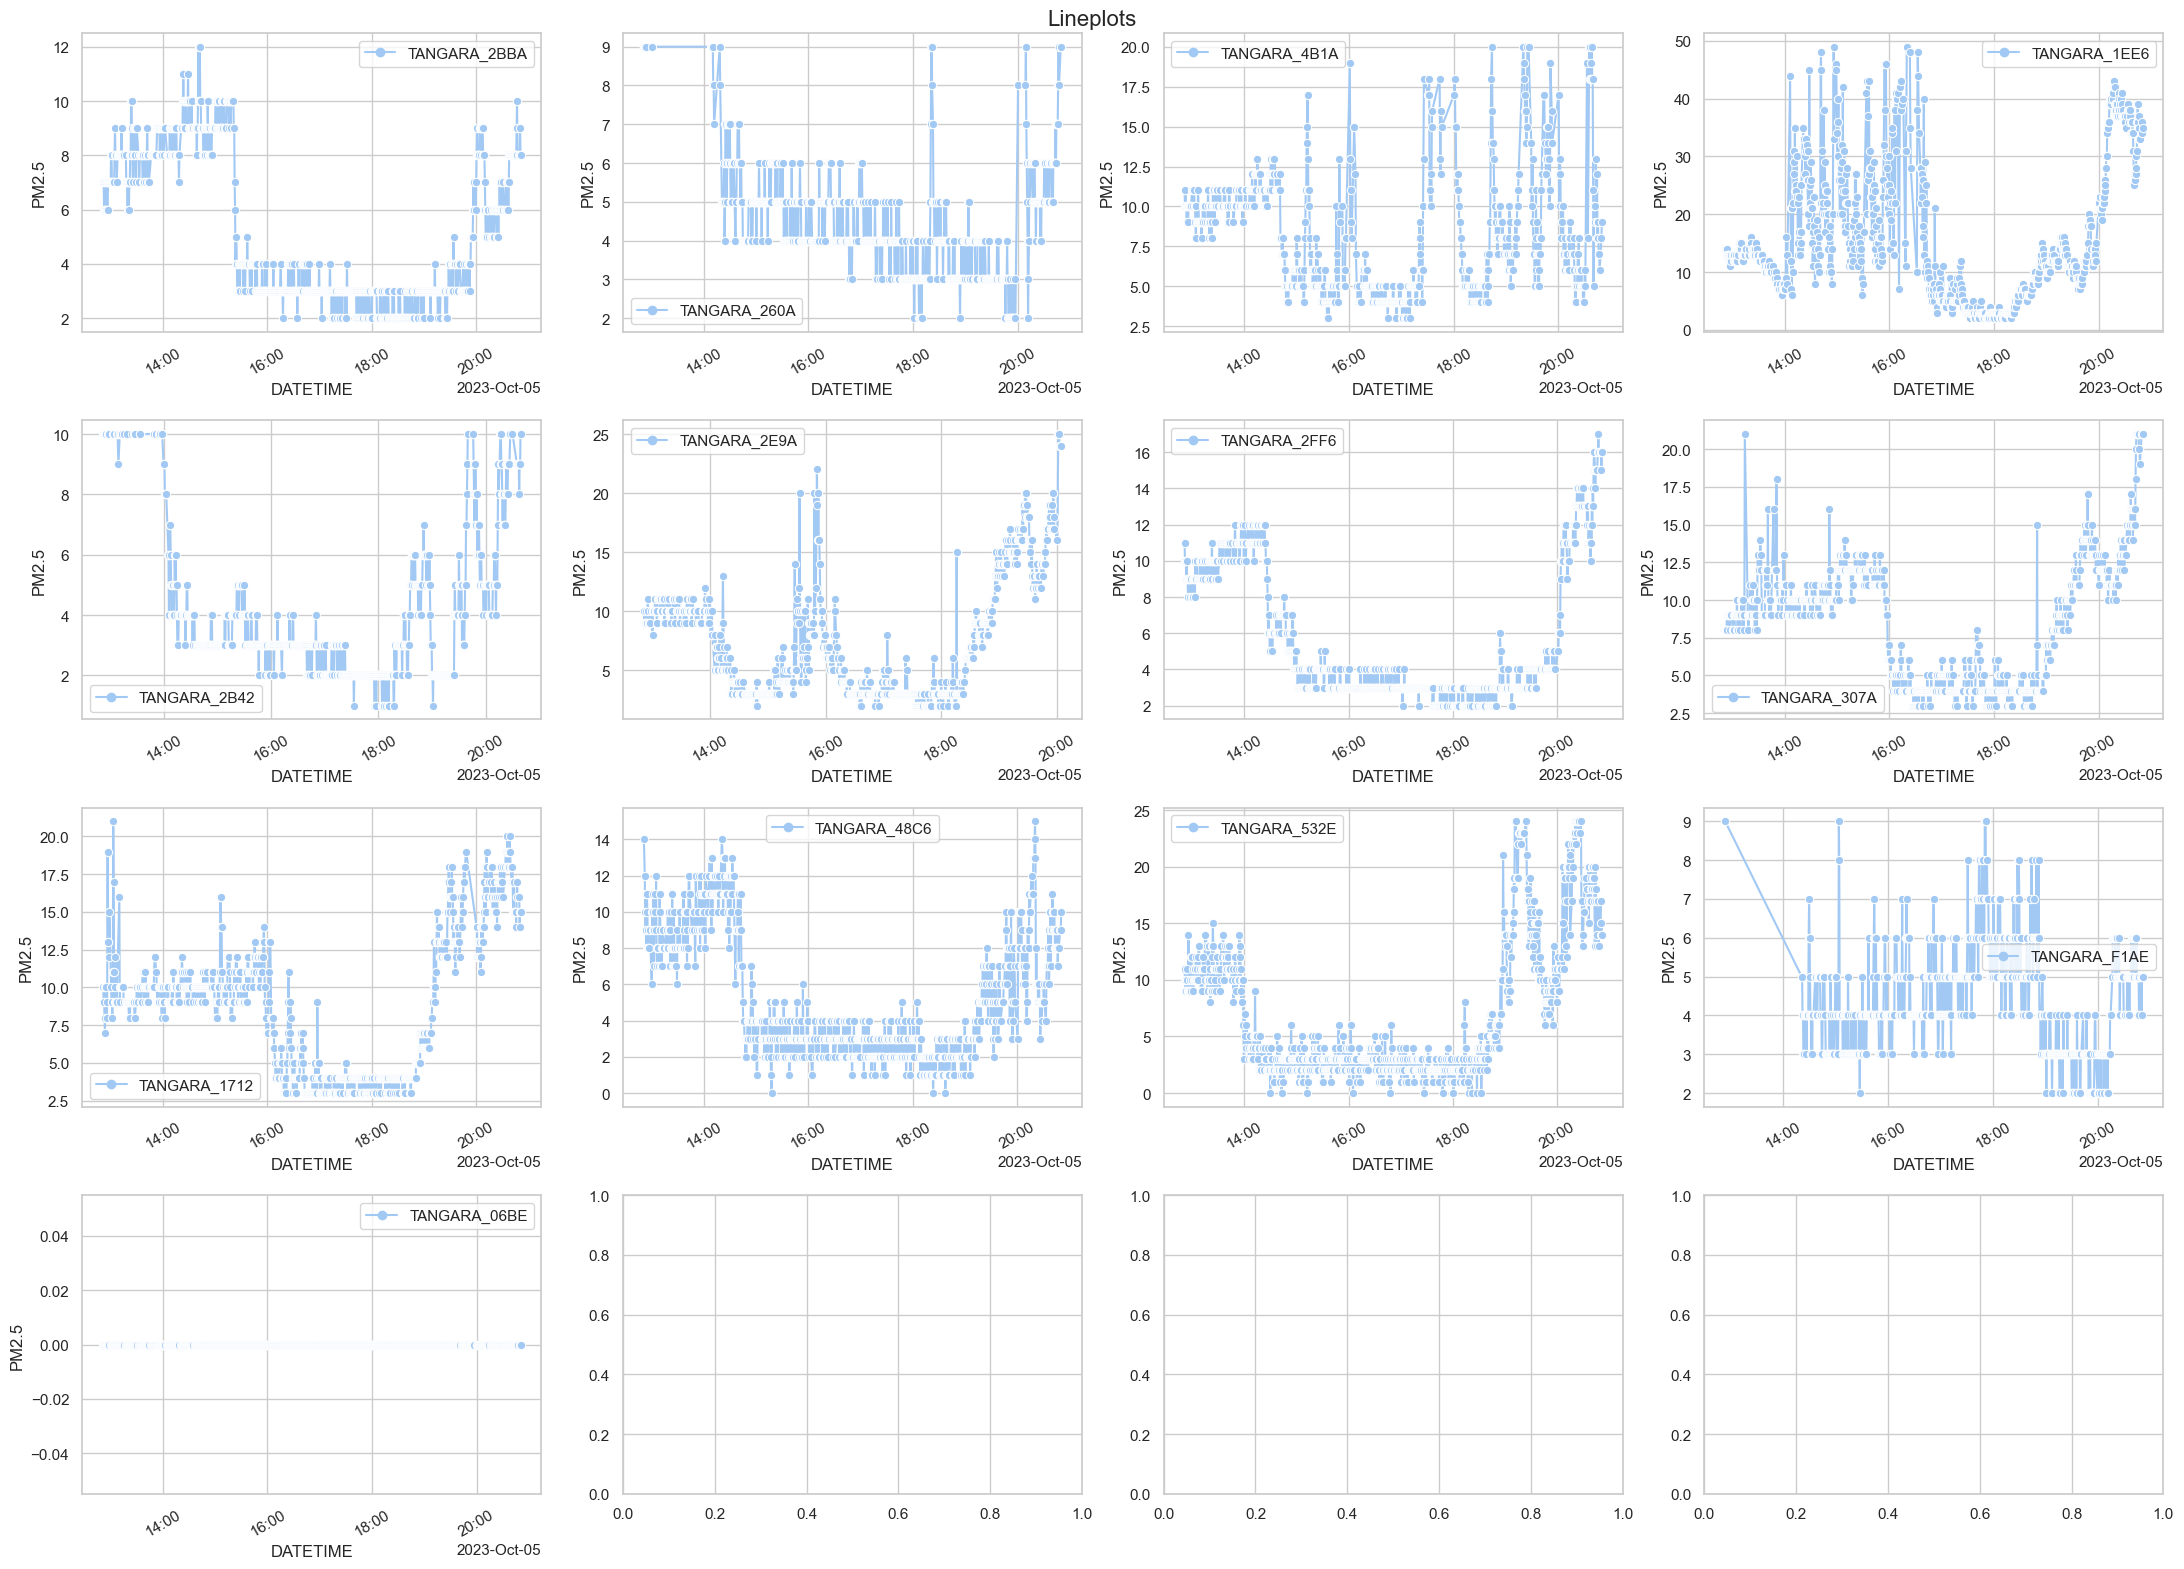

In [14]:
# Plot Lineplots
plot_lines(df_pm25_clean)

In [15]:
# Save PM2.5 Data Frame Sensors into CSV file
df_to_csv(df_pm25_clean, "pm25_clean.csv", datafolder='1_clean')